In [1]:
%load_ext autoreload
%autoreload 2

import IPython
from pathlib import Path
import os
locals = IPython.extract_module_locals() # type: ignore
notebook_name = "/".join(locals[1]["__vsc_ipynb_file__"].split("/"))
os.chdir(Path(notebook_name).parent.parent)

In [2]:
from retail_recommender_system.utils import batch_dict_to_device, split_by_time
import polars as pl
from torch.utils.data import DataLoader
from retail_recommender_system.models.deepfm import *
from retail_recommender_system.models.mf import *
from retail_recommender_system.models.mfconv import *
from retail_recommender_system.data.loader import *
from retail_recommender_system.evaluation.metrics import *

from retail_recommender_system.models.mfconv import collate_fn

In [3]:
dataset = load_dataset(DataConfig(dataset="hm", prefix="frac_0_01"))
dataset.load()

In [94]:
X_train, X_valid = split_by_time(
    dataset.data["relations"], date_col=dataset.namings["date"], validation_ratio=0.3
)

val_dataset = MFConvDataset(
    relations=X_valid,
    users=dataset.data["users"],
    items=dataset.data["items"],
    namings=dataset.namings,
    neg_sampl=0,
)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False, collate_fn=collate_fn)

model = MFConv(
    MFConvModelConfig(n_users=dataset.n_users, n_items=dataset.n_items, emb_size=16, )
)
#eval_dataset = MFConvEvalDataset(base_dataset=val_dataset, user_batch_size=5)

In [95]:
from tqdm import tqdm

for i in tqdm(val_loader):
    print(i["i_img"].shape)

  0%|          | 1/371 [00:01<10:29,  1.70s/it]

torch.Size([256, 3, 28, 28])


  1%|          | 2/371 [00:03<10:07,  1.65s/it]

torch.Size([256, 3, 28, 28])


  1%|          | 3/371 [00:04<09:48,  1.60s/it]

torch.Size([256, 3, 28, 28])


  1%|          | 4/371 [00:06<09:45,  1.59s/it]

torch.Size([256, 3, 28, 28])


  1%|▏         | 5/371 [00:07<09:29,  1.56s/it]

torch.Size([256, 3, 28, 28])


  2%|▏         | 6/371 [00:09<08:43,  1.43s/it]

torch.Size([256, 3, 28, 28])


  2%|▏         | 7/371 [00:10<08:28,  1.40s/it]

torch.Size([256, 3, 28, 28])


  2%|▏         | 8/371 [00:11<08:14,  1.36s/it]

torch.Size([256, 3, 28, 28])


  2%|▏         | 9/371 [00:12<07:51,  1.30s/it]

torch.Size([256, 3, 28, 28])


  3%|▎         | 10/371 [00:14<07:31,  1.25s/it]

torch.Size([256, 3, 28, 28])


  3%|▎         | 11/371 [00:15<07:18,  1.22s/it]

torch.Size([256, 3, 28, 28])


  3%|▎         | 12/371 [00:16<07:12,  1.21s/it]

torch.Size([256, 3, 28, 28])


  4%|▎         | 13/371 [00:17<07:06,  1.19s/it]

torch.Size([256, 3, 28, 28])


  4%|▍         | 14/371 [00:18<06:45,  1.14s/it]

torch.Size([256, 3, 28, 28])


  4%|▍         | 15/371 [00:19<06:36,  1.11s/it]

torch.Size([256, 3, 28, 28])


  4%|▍         | 16/371 [00:20<06:39,  1.13s/it]

torch.Size([256, 3, 28, 28])


  5%|▍         | 17/371 [00:21<06:32,  1.11s/it]

torch.Size([256, 3, 28, 28])


  5%|▍         | 18/371 [00:22<06:11,  1.05s/it]

torch.Size([256, 3, 28, 28])


  5%|▌         | 19/371 [00:23<06:05,  1.04s/it]

torch.Size([256, 3, 28, 28])


  5%|▌         | 20/371 [00:24<05:52,  1.01s/it]

torch.Size([256, 3, 28, 28])


  6%|▌         | 21/371 [00:25<05:42,  1.02it/s]

torch.Size([256, 3, 28, 28])


  6%|▌         | 22/371 [00:26<05:43,  1.02it/s]

torch.Size([256, 3, 28, 28])


  6%|▌         | 23/371 [00:27<05:37,  1.03it/s]

torch.Size([256, 3, 28, 28])


  6%|▋         | 24/371 [00:28<05:41,  1.02it/s]

torch.Size([256, 3, 28, 28])


  7%|▋         | 25/371 [00:29<05:45,  1.00it/s]

torch.Size([256, 3, 28, 28])


  7%|▋         | 26/371 [00:30<05:52,  1.02s/it]

torch.Size([256, 3, 28, 28])


  7%|▋         | 27/371 [00:31<05:45,  1.00s/it]

torch.Size([256, 3, 28, 28])


  8%|▊         | 28/371 [00:32<05:55,  1.04s/it]

torch.Size([256, 3, 28, 28])


  8%|▊         | 29/371 [00:33<06:08,  1.08s/it]

torch.Size([256, 3, 28, 28])


  8%|▊         | 30/371 [00:34<06:02,  1.06s/it]

torch.Size([256, 3, 28, 28])


  8%|▊         | 31/371 [00:35<05:54,  1.04s/it]

torch.Size([256, 3, 28, 28])


  9%|▊         | 32/371 [00:37<05:59,  1.06s/it]

torch.Size([256, 3, 28, 28])


  9%|▉         | 33/371 [00:38<05:59,  1.06s/it]

torch.Size([256, 3, 28, 28])


  9%|▉         | 34/371 [00:39<06:02,  1.08s/it]

torch.Size([256, 3, 28, 28])


  9%|▉         | 35/371 [00:40<05:55,  1.06s/it]

torch.Size([256, 3, 28, 28])


 10%|▉         | 36/371 [00:41<06:07,  1.10s/it]

torch.Size([256, 3, 28, 28])


 10%|▉         | 37/371 [00:42<06:04,  1.09s/it]

torch.Size([256, 3, 28, 28])


 10%|█         | 38/371 [00:43<05:53,  1.06s/it]

torch.Size([256, 3, 28, 28])


 11%|█         | 39/371 [00:44<05:36,  1.01s/it]

torch.Size([256, 3, 28, 28])


 11%|█         | 40/371 [00:45<05:33,  1.01s/it]

torch.Size([256, 3, 28, 28])


 11%|█         | 41/371 [00:46<05:29,  1.00it/s]

torch.Size([256, 3, 28, 28])


 11%|█▏        | 42/371 [00:47<05:23,  1.02it/s]

torch.Size([256, 3, 28, 28])


 11%|█▏        | 42/371 [00:47<06:13,  1.13s/it]


KeyboardInterrupt: 

In [60]:
b = next(iter(val_loader))

In [23]:
model.conv(b["i_img"])

tensor([[ 0.0351, -0.0768,  0.1168,  ...,  0.0120,  0.0951, -0.0412],
        [ 0.0104, -0.0850,  0.1527,  ..., -0.0027,  0.0931, -0.0455],
        [ 0.0364, -0.0680,  0.1129,  ..., -0.0150,  0.0824, -0.0387],
        ...,
        [ 0.0497, -0.0813,  0.1187,  ..., -0.0086,  0.1065, -0.0179],
        [ 0.0020, -0.1090,  0.1518,  ..., -0.0557,  0.0953, -0.0597],
        [ 0.0081, -0.0886,  0.0984,  ..., -0.0477,  0.0822, -0.0792]],
       grad_fn=<AddmmBackward0>)

In [ ]:
model(b)

In [ ]:
val_dataset[0]["i_img"][0].shape

In [101]:
from PIL import Image

# Replace 'path_to_image' with the actual path to your image file
image_path = '.data/hm/base/images/061/0616100001.jpg'
image = Image.open(image_path)
image.show()

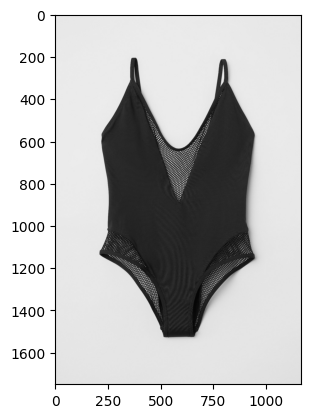

In [105]:
import numpy as np
np_image = np.array(image)
np_stack_image = np.stack((np_image,)*3, axis=-1)
plt.imshow(np.array(np_stack_image))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [93.951965..1051.5358].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [251.1572..1060.4642].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [69.39285..1042.6072].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [118.5..1047.0714].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [211.8559..1047.0714].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [531.52893..1051.5358].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [269.30667..1047.0845].

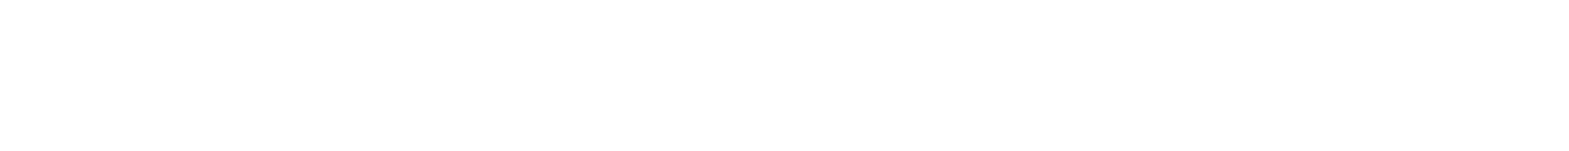

In [103]:
from PIL import Image
import torch
import numpy as np

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 10, figsize=(20, 5))
for i in range(10):
    ax[i].imshow(val_dataset[i]["i_img"][0].permute(1, 2, 0))
    ax[i].axis('off')
plt.show()

In [97]:
train_dataset = MFConvDataset(
    relations=dataset.data["relations"],
    users=dataset.data["users"],
    items=dataset.data["items"],
    namings=dataset.namings,
    neg_sampl=1,
)

In [98]:
loader = DataLoader(train_dataset, batch_size=3, shuffle=True, collate_fn=collate_fn)

In [99]:
iter_loader = iter(loader)

In [ ]:
model = MFConv(MFConvModelConfig(
    n_users=dataset.n_users, 
    n_items=dataset.n_items,
    emb_size=8
))
model(next(iter_loader))

In [54]:
df  =pl.DataFrame({"value": range(1, 101)})

In [ ]:
df[3:]